In [40]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

In [41]:
train_dataset = torchvision.datasets.FashionMNIST(
  root='.',
  train=True,
  transform= transforms.ToTensor(),
  download=True
)

In [42]:
train_dataset.data.max()

tensor(255, dtype=torch.uint8)

In [43]:
train_dataset.data.shape

torch.Size([60000, 28, 28])

In [44]:
train_dataset.targets

tensor([9, 0, 0,  ..., 3, 0, 5])

In [45]:
test_dataset = torchvision.datasets.FashionMNIST(
  root= '.',
  train=False,
  transform=transforms.ToTensor(),
  download=True
)

In [46]:
classes = len(set(train_dataset.targets.numpy()))
print(f"We have {classes} types of clothing")

We have 10 types of clothing


In [47]:
class CNN(nn.Module):
  def __init__(self, K):
    super(CNN, self).__init__()
    self.convolution_layers = nn.Sequential(
      nn.Conv2d(in_channels=1,out_channels=32,kernel_size=3,stride=2),
      nn.ReLU(),
      nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3,stride=2),
      nn.ReLU(),
      nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3,stride=2),
      nn.ReLU(),
    )
    self.dense_layers = nn.Sequential(
      nn.Dropout(0.2),
      nn.Linear(128*2*2, 512),
      nn.ReLU(),
      nn.Dropout(0.2),
      nn.Linear(512,K)
    )
  def forward(self, X):
    out = self.convolution_layers(X)
    out = out.view(out.size(0), -1)
    out = self.dense_layers(out)
    return out

In [48]:
model = CNN(classes)

In [49]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)

cpu


CNN(
  (convolution_layers): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2))
    (3): ReLU()
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2))
    (5): ReLU()
  )
  (dense_layers): Sequential(
    (0): Dropout(p=0.2, inplace=False)
    (1): Linear(in_features=512, out_features=512, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)

In [50]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

In [51]:
batch_size = 128

train_loader = torch.utils.data.DataLoader(dataset= train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

In [52]:
def batch_gd(model, criterion, optimizer, train_loader, test_loader, epochs):
  train_losses = np.zeros(epochs)
  test_losses = np.zeros(epochs)

  for it in range(epochs):
    model.train()
    t0 = datetime.now()
    train_loss = []
    for inputs, targets in train_loader:
      inputs, targets = inputs.to(device), targets.to(device)
      optimizer.zero_grad()
      outputs = model(inputs)
      loss = criterion(outputs, targets)
      loss.backward()
      optimizer.step()
      train_loss.append(loss.item())
    train_loss = np.mean(train_loss)
    model.eval()
    test_loss = []
    for inputs, targets in test_loader:
      inputs, targets = inputs.to(device), targets.to(device)
      outputs = model(inputs)
      loss = criterion(outputs, targets)
      loss.backward()
      test_loss.append(loss.item())
    test_loss = np.mean(test_loss)
    train_losses[it] = train_loss
    test_losses[it] = test_loss
    dt = datetime.now() - t0
    print(f'Epoch {it+1}/{epochs}, train loss: {train_loss:.4f}, test loss: {test_loss:.4f}, duration: {dt}')
  return train_losses, test_losses

In [53]:
train_losses, test_losses = batch_gd(model,criterion,optimizer,train_loader,test_loader,15)

Epoch 1/15, train loss: 0.6525, test loss: 0.4799, duration: 0:00:46.273662
Epoch 2/15, train loss: 0.4386, test loss: 0.4118, duration: 0:00:47.478759
Epoch 3/15, train loss: 0.3780, test loss: 0.3760, duration: 0:00:49.757377
Epoch 4/15, train loss: 0.3407, test loss: 0.3363, duration: 0:00:48.980316
Epoch 5/15, train loss: 0.3131, test loss: 0.3254, duration: 0:00:49.182708
Epoch 6/15, train loss: 0.2881, test loss: 0.3097, duration: 0:00:49.085103
Epoch 7/15, train loss: 0.2708, test loss: 0.2949, duration: 0:00:49.632952
Epoch 8/15, train loss: 0.2556, test loss: 0.2984, duration: 0:00:49.243439
Epoch 9/15, train loss: 0.2401, test loss: 0.2882, duration: 0:00:49.679721
Epoch 10/15, train loss: 0.2260, test loss: 0.2864, duration: 0:00:49.375299
Epoch 11/15, train loss: 0.2123, test loss: 0.2832, duration: 0:00:49.528284
Epoch 12/15, train loss: 0.1992, test loss: 0.2842, duration: 0:00:49.780104
Epoch 13/15, train loss: 0.1881, test loss: 0.2916, duration: 0:00:49.463302
Epoch 14

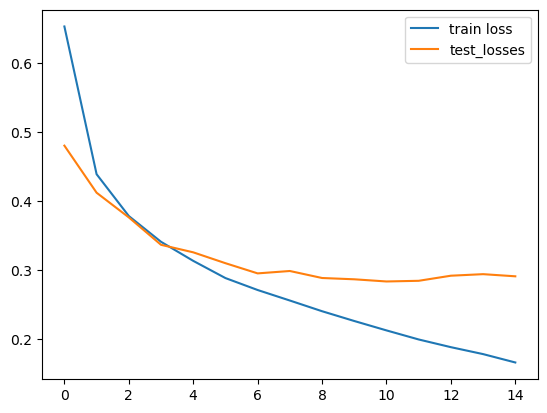

In [54]:
plt.plot(train_losses, label= 'train loss')
plt.plot(test_losses, label = 'test_losses')
plt.legend()
plt.show()

In [55]:
model.eval()
n_correct = 0. 
n_total = 0. 

for inputs, targets in train_loader:
  inputs, targets = inputs.to(device), targets.to(device)
  outputs = model(inputs)
  _,predictions = torch.max(outputs, 1)
  n_correct += (predictions == targets).sum().item()
  n_total += targets.shape[0]
train_acc = n_correct/n_total

for inputs, targets in test_loader:
  inputs, targets = inputs.to(device), targets.to(device)
  outputs = model(inputs)
  _, predictions = torch.max(outputs,1)
  n_correct += (predictions == targets).sum().item()
  n_total += targets.shape[0]
test_acc = n_correct/n_total

print(f'Train accuracy: {train_acc: .4f}, Test accuracy: {test_acc: .4f}')

Train accuracy:  0.9557, Test accuracy:  0.9482


In [56]:
from sklearn.metrics import confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes, normalize=False,title='Confusion matrix', cmap=plt.cm.Blues):
  if normalize:
    cm = cm.astype('float') /cm.sum(axis = 1)[:,np.newaxis]
    print("Normalized Confusion Matrix")
  else:
    print('Confusion matrix, without normalization')
  print(cm)
  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)
  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.

  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j,i,format(cm[i,j], fmt),
    horizontalalignment='center',
    color='white' if cm[i, j] >thresh else 'black')
  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()

Confusion matrix, without normalization
[[887   1  24  15   3   1  66   0   3   0]
 [  1 978   1  12   2   0   5   0   1   0]
 [ 17   1 884   7  43   0  47   0   1   0]
 [ 13  11  19 896  32   0  29   0   0   0]
 [  1   1  56  22 861   0  59   0   0   0]
 [  1   0   0   1   0 968   0  25   0   5]
 [122   0  69  25 109   0 668   0   7   0]
 [  0   0   0   0   0   5   0 980   0  15]
 [  3   2   5   5   6   2   6   3 966   2]
 [  1   0   0   0   0   5   0  49   0 945]]


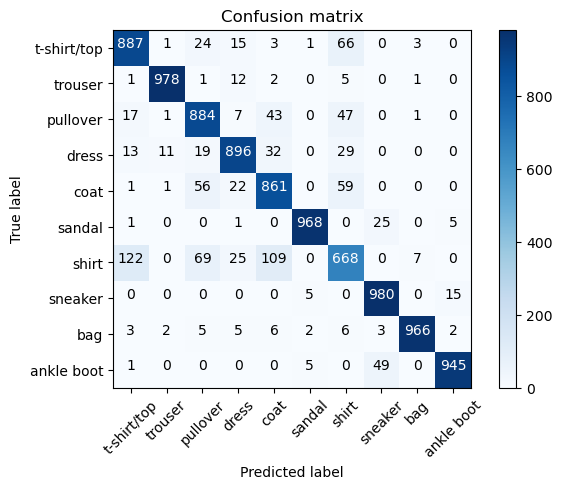

In [58]:
x_test = test_dataset.data.numpy()
y_test = test_dataset.targets.numpy()
p_test = np.array([])
labels = ['t-shirt/top', 'trouser', 'pullover', 'dress', 'coat', 'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
for inputs, targets in test_loader:
  inputs, targets = inputs.to(device), targets.to(device)
  outputs = model(inputs)
  _,predictions = torch.max(outputs,1)
  p_test = np.concatenate((p_test, predictions.cpu().numpy()))
cm = confusion_matrix(y_test, p_test)
plot_confusion_matrix(cm,labels)

Text(0.5, 1.0, 'True Label: shirt Predicted: dress')

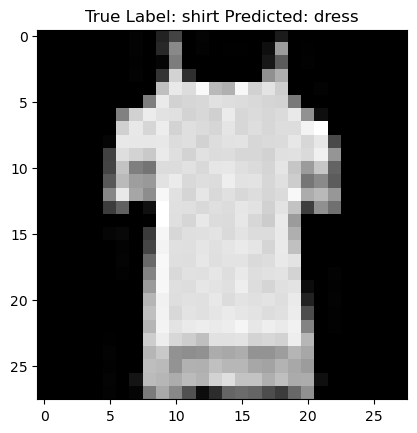

In [61]:
p_test = p_test.astype(np.uint8)
misclassified_idx = np.where(p_test != y_test)[0]
i = np.random.choice(misclassified_idx)
plt.imshow(x_test[i].reshape(28,28), cmap = 'gray')
plt.title("True Label: %s Predicted: %s" % (labels[y_test[i]], labels[p_test[i]]))